# Looking at the goodness of fit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from bayesn import SEDmodel
import os
import pandas as pd
import pickle

## Make a list of SN

In [2]:
directory = os.fsencode("/root/partiiiproject/Archive")
supernovae_names = ["sn2006hb"]
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".dat"): 
        supernovae_names.append(filename[:-4])
        continue
    else:
        continue

## Load the W22 Model

W22 model works with optical and NIR bands

In [3]:
model = SEDmodel(load_model='W22_model')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /root/partiiiproject
Loading built-in model W22_model
Loading built-in reddening law F99


## Define which SN we are looking at and which bands

In [4]:
supernova_name = "sn2005A"
dust_law = "F99"
supernova_file = "/root/partiiiproject/Archive/"+supernova_name+".dat"


## Load Observational Data

We read the observational data and its assosciated uncertainty 

In [5]:
meta, lcdata = sncosmo.read_snana_ascii(supernova_file, default_tablename='OBS')
lcdata = lcdata['OBS'].to_pandas()

## Use chains to get Fits to plot

Choose the bands we want to plot and the number of days on either side of the peak.

In [6]:

t_obs = lcdata['MJD'] - meta['SEARCH_PEAKMJD']
bands = np.unique(lcdata['FLT']) #['g_CSP', 'r_CSP', 'i_CSP', 'B_CSP', 'V_CSP', 'Y_RC', 'J_RC1', 'H_RC']
z = meta['REDSHIFT_FINAL']
ebv_mw = meta['MWEBV']

sampleChainsDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_chains.pkl"
sampleSummaryDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_fit_summary.csv"

samplesSummary = pd.read_csv(sampleSummaryDir)
samplesSummary = samplesSummary.rename(index=samplesSummary['Unnamed: 0'])

t_obs = np.unique(t_obs)

In [7]:
with open(sampleChainsDir, 'rb') as file:
    chains = pickle.load(file)

## Simulate Light Curves using parameters from fit

In [8]:
N=1
fit_mu = np.mean(chains['mu'])
fit_theta = np.mean(chains['theta'])
fit_RV = np.mean(chains['RV'])
fit_AV = np.mean(chains['AV'])
fit_tmax = np.mean(chains['tmax'])
fit_delM = np.mean(chains['delM'])

fit_eps_inner = chains['eps']
fit_eps_inner = np.reshape(fit_eps_inner, (4, 250, 9, 6), order='F')
fit_eps = np.zeros((4, 250, 11, 6))
fit_eps[:,:,1:-1,:] = fit_eps_inner

fit_eps = fit_eps.mean(axis = 1)
fit_eps = fit_eps.mean(axis = 0)
fit_eps = np.reshape(fit_eps, (1 , 11, 6))
print(fit_eps.shape)

print(model.l_knots.shape[0])
print(model.tau_knots.shape[0])

sim = model.simulate_light_curve(t_obs, N, bands, mu=fit_mu, theta=fit_theta,  z=z, ebv_mw=ebv_mw, mag=False, write_to_files=False, AV=fit_AV, RV=fit_RV, redlaw=dust_law, tmax=fit_tmax, eps=fit_eps)
flux, flux_err, params = sim

flux = np.reshape(flux,(len(bands),len(t_obs)))

(1, 11, 6)
11
6


## Compare Simulation and fitted light curve

In [9]:


flux_grid = model.get_flux_from_chains(t_obs, bands, sampleChainsDir, z, ebv_mw, mag=False, num_samples=10)
fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))


Getting best fit light curves from chains...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]


## Plot Graphs

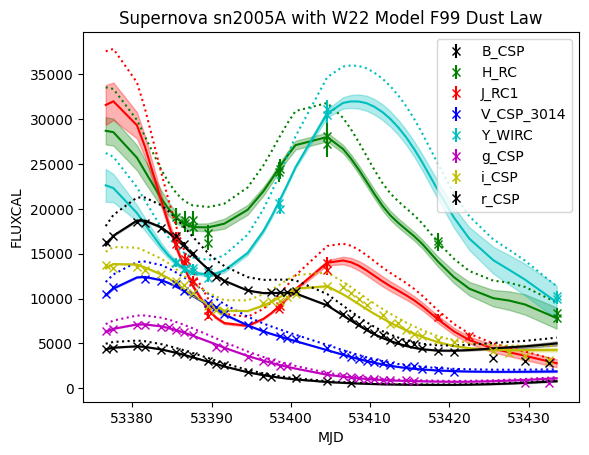

In [10]:
cs = ['k','g', 'r', 'b', 'c', 'm', 'y', 'k','g', 'y', 'b', 'c', 'm']
plot_t = t_obs + meta['SEARCH_PEAKMJD']

for b_ind, b in enumerate(bands):
    
    if b == 'u_CSP':
        continue
    #Observed
    b_data = lcdata[lcdata.FLT == b]
    plt.errorbar(b_data.MJD, b_data.FLUXCAL, b_data.FLUXCALERR, fmt=f'{cs[b_ind]}x', label=b)

    #From fit
    plt.plot(plot_t, fit[b_ind, :], color=cs[b_ind])
    plt.fill_between(plot_t, fit[b_ind, :] - fit_err[b_ind, :], fit[b_ind, :] + fit_err[b_ind, :], alpha=0.3, color=cs[b_ind])

    #From simulation 
    plt.plot(t_obs+meta['SEARCH_PEAKMJD'], flux[b_ind,:], color=cs[b_ind], linestyle='dotted')
   
plt.title(rf'Supernova '+supernova_name+' with W22 Model ' + dust_law +' Dust Law')
plt.xlabel('MJD')
plt.ylabel('FLUXCAL')
plt.legend()
#plt.figtext(0.5, .8, rf"Mean $A_v$ =  {np.mean(samples['AV']):.2f}")
#plt.figtext(0.5, .75, rf"Std $A_v$ =  {np.std(samples['AV']):.2f}")
#plt.figtext(0.5, .7, rf"Mean $R_v$ =  {np.mean(samples['RV']):.2f}")
#plt.figtext(0.5, .65, rf"Std $A_v$ =  {np.std(samples['RV']):.2f}")
#plt.savefig("/root/partiiiproject/DustLawsGeneralGraphs/simulation"+supernova_name+dust_law+".png", bbox_inches='tight') 
plt.show()

## Chi squared error

In [11]:
"""chi_squared = np.zeros(len(lcdata))
for i, entry in lcdata.iterrows():
    if entry.FLT == 'u_csp':
        continue
    index_t_obs = np.where(t_obs == (entry.MJD-meta['SEARCH_PEAKMJD']))
    index_band = np.where(bands == entry.FLT)
    Exp = flux[index_band, index_t_obs]
    Obs = entry.FLUXCAL
    chi_squared[i] = ((Obs-Exp)**2)/Exp"""

chi_squared = np.zeros(len(lcdata))
for i, entry in lcdata.iterrows():
    if entry.FLT == 'u_CSP':
        continue
    index_t_obs = np.where(t_obs == (entry.MJD-meta['SEARCH_PEAKMJD']))
    index_band = np.where(bands == entry.FLT)
    Exp = flux[index_band, index_t_obs]
    Exp = Exp[0]
    Obs = entry.FLUXCAL
    ObsErr = entry.FLUXCALERR
    chi_squared_calc = ((Obs-Exp)**2)/(ObsErr**2)
    chi_squared[i] = chi_squared_calc


/tmp/ipykernel_32469/4262707048.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc


In [12]:
print(np.mean(chi_squared))

121.51845861734616


## Plotting Chi Squared for each wavelength

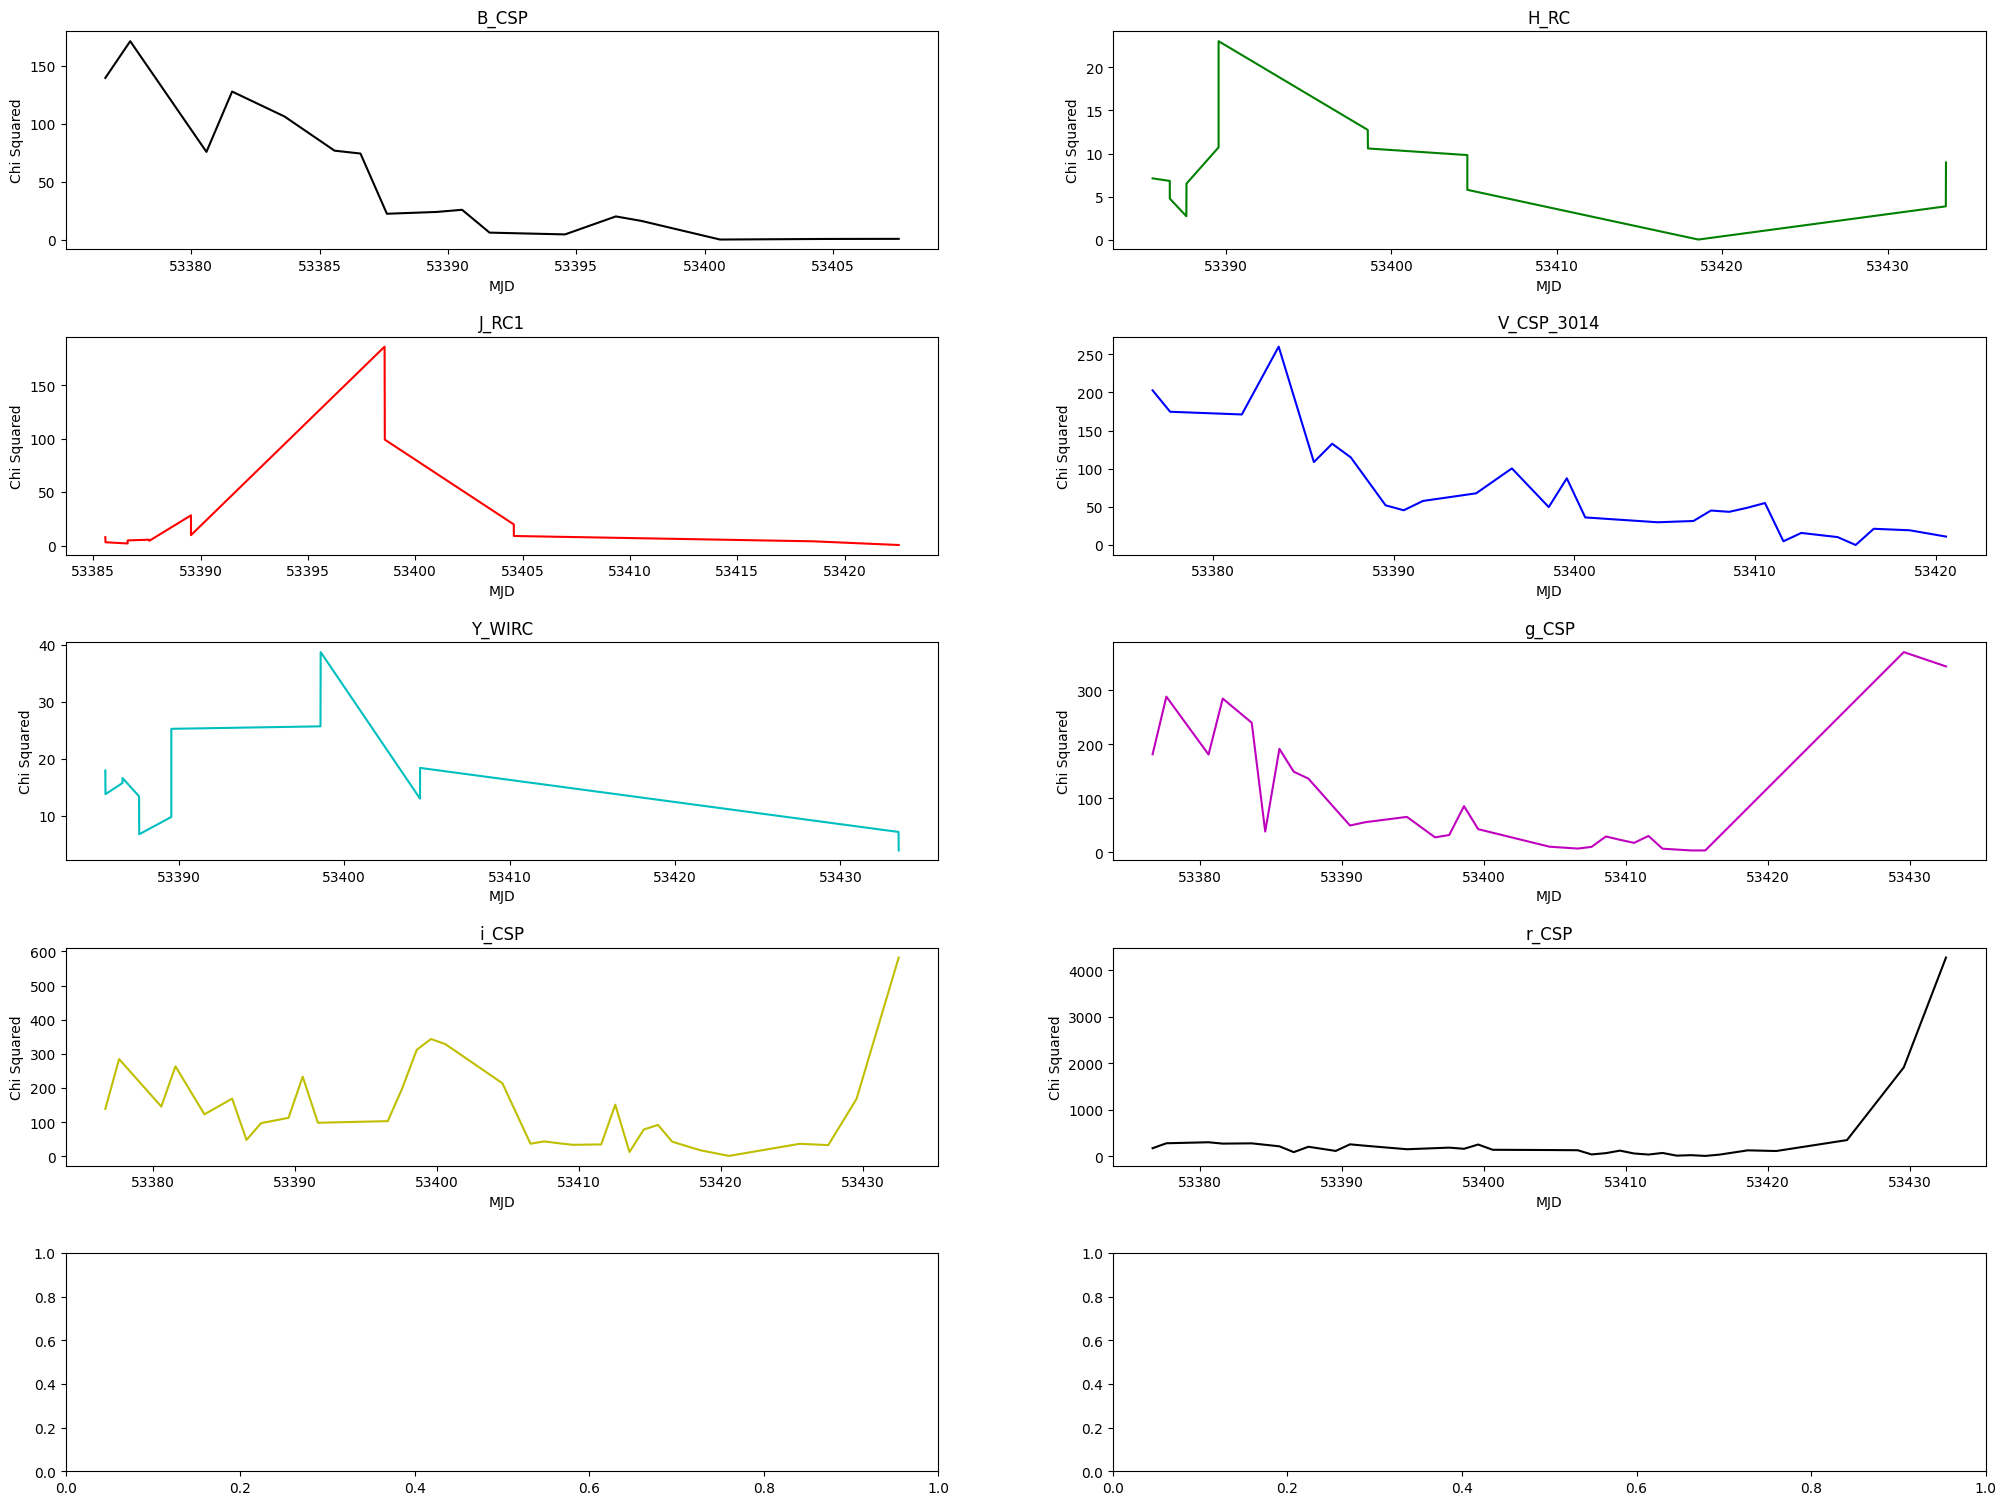

In [13]:
figure, axis = plt.subplots(1+len(bands)//2, 2) #Sub plots 3 rows and 2 columns
for b_ind, b in enumerate(bands): #Loop through the bands given
    b_data = lcdata[lcdata.FLT == b] #get the original data for the band (previous method took first character!)
    indexes_for_bands = lcdata.index[lcdata.FLT == b].tolist()
    axis[b_ind//2, b_ind%2].plot(b_data.MJD, chi_squared[indexes_for_bands], color=cs[b_ind])
    axis[b_ind//2, b_ind%2].set_title(b)
    axis[b_ind//2, b_ind%2].set_xlabel('MJD')
    axis[b_ind//2, b_ind%2].set_ylabel('Chi Squared')
#axis.legend()
plt.subplots_adjust(left=0, right=3, bottom=0, top=3, wspace=0.2, hspace=0.4)
figure.show()